In [ ]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow.keras.metrics
from tensorflow.keras.utils import to_categorical
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
pd.options.display.max_columns
pd.options.display.max_rows
from tensorflow.keras.utils import to_categorical
pd.options.display.max_rows

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


60

In [ ]:
!git clone https://github.com/Jmazo25/Monografia.git

Cloning into 'Monografia'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [ ]:
df = pd.read_csv("/content/Monografia/train.csv")

#Búsqueda de nulos

Previamente ya se detectató una fila con valores nulos por lo cual se procede a eliminar

In [ ]:
df.dropna(axis = 0, how ='any',inplace=True)
df.reset_index(inplace=True)
df.shape

(27480, 5)

In [ ]:
df.head(3)

,index,textID,text,selected_text,sentiment
0,0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,2,088c60f138,my boss is bullying me...,bullying me,negative


#Eiliminación de stop words

In [ ]:
def clean_text(t):
  tl = []
  t = t.lower().split()
  for i in t:
    if i not in stopwords.words('english'):
      tl.append(i)
  return " ".join(tl)

In [ ]:
#Limpiar expresiones Regulares
df['text'] = df['text'].apply((lambda x:re.sub('@[^\s]+','',x)))
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#Remover stopwords
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [ ]:
##Limpiar expresiones Regulares
df['selected_text'] = df['selected_text'].apply((lambda x:re.sub('@[^\s]+','',x)))
df['selected_text'] = df['selected_text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#Remover StopWords
df['selected_text'] = df['selected_text'].apply(lambda x: clean_text(x))

#máxima longitud de un tweet en el dataset

Se procede a buscar el tweet con mayor longitud en términos de palabras

In [ ]:
dim_tw = df['text'].str.split().str.len()

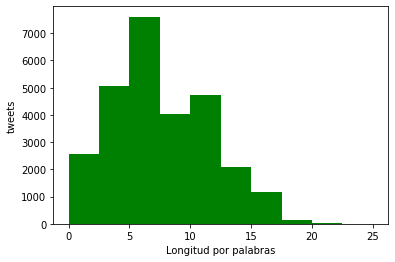

In [ ]:
fig, ax1 = plt.subplots()
plt.hist(dim_tw,color='green')
ax1.set_xlabel('Longitud por palabras'), ax1.set_ylabel("tweets")
plt.show()

In [ ]:
dim_tw.describe()

count    27480.000000
mean         7.416230
std          3.983212
min          0.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         25.000000
Name: text, dtype: float64

In [ ]:
df.head(5)

,index,textID,text,selected_text,sentiment
0,0,cb774db0d1,i`d responded going,i`d responded going,neutral
1,1,549e992a42,sooo sad miss san diego,sooo sad,negative
2,2,088c60f138,boss bullying,bullying,negative
3,3,9642c003ef,interview leave alone,leave alone,negative
4,4,358bd9e861,sons couldn`t put releases already bought,sons,negative


##Decodificación de la variable objetivo

Funciones que permiten extraer los índices inicial y final del texto seleccionado del tweet

In [ ]:
def ind(t1,t2):
    l = []
    ini = int
    fin = int
    t1 = t1.lower().split()
    t2 = t2.lower().split()
    for i in t2:
        for ind,j in enumerate(t1):
          if i == j:
            l.append(ind)
    if l != []:
        ini=(l[0])
        fin=(l[-1])
    else:
        ini = 0
        fin = 0
    return ini

In [ ]:
def ind2(t1,t2):
  l = []
  ini = int
  fin = int
  t1 = t1.lower().split()
  t2 = t2.lower().split()
  for i in t2:
    for ind,j in enumerate(t1):
      if i == j:
        l.append(ind)
  if l != []:
    ini=(l[0])
    fin=(ini+len(t2)-1)
  else:
    ini = 0
    fin = 0
  return fin

test funciones

In [ ]:
f= ind('no. lost link sent pull battery.','lost')
f

1

Creación de dataset donde se manipularán los datos

In [ ]:
df2 = df[['text','selected_text']] 

Aplicación de las funciones de consecución de índices

In [ ]:
y_true_i = df2.apply(lambda x: ind(x['text'],x['selected_text']),axis=1)

In [ ]:
y_true_f = df2.apply(lambda x: ind2(x['text'],x['selected_text']),axis=1)

Validación de índices negativos

In [ ]:
a = [(y_true_i[p],y_true_f[p]) for p in range(y_true_i.shape[0]) if y_true_i[p] > y_true_f[p]]
a

[]

Agregar dos variables al dataset con índice inicial y final

In [ ]:
df2['start_w'] = y_true_i
df2['end_w'] = y_true_f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


validación de tipo de datos en cada las dos variables previamente generadas

In [ ]:
val_shape_f = [(type(y_true_f)) for i in range(y_true_f.shape[0]) if type(y_true_f[i]) != type(y_true_f[0]) ]
val_shape_i = [(type(y_true_i)) for i in range(y_true_i.shape[0]) if type(y_true_i[i]) != type(y_true_i[0]) ]
val_shape_f, val_shape_i

([], [])

#Longitud de cada tweet

Se almacena en una variable la longitud de cada tweet esto para remover el padding al calcular las métricas luego de realizar una predicción al conjunto de test

In [ ]:
def leng2(x):
  return len(x.lower().split())

In [ ]:
def leng(x):
  x = x.lower().split()
  a = len(x)
  return a

In [ ]:
a = 'hola mi nombre es Gufy y soy el mejor perro del mundo'
b = leng2(a)
c = leng(a)
print(b,c)

12 12


In [ ]:
long = df2.apply(lambda x: leng(x['text']),axis=1)
long = np.array(long)

In [ ]:
df2.head()

,text,selected_text,start_w,end_w
0,i`d responded going,i`d responded going,0,2
1,sooo sad miss san diego,sooo sad,0,1
2,boss bullying,bullying,1,1
3,interview leave alone,leave alone,1,2
4,sons couldn`t put releases already bought,sons,0,0


#One-hot encodding

In [ ]:
y_true_i = to_categorical(y_true_i)

In [ ]:
y_true_i

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_true_i.shape, y_true_f.shape

((27480, 23), (27480, 25))

In [ ]:
y_true_f = to_categorical(y_true_f)

In [ ]:
y_true_f.shape, y_true_i.shape

((27480, 25), (27480, 22))

#Padding

Se agrega pading al arreglo con los vectores que tienen la posición inicial debido a que poseen menor longitud

In [ ]:
def pad(a,ml):
  if len(a) == 0:
    c = np.zeros(ml)
  else:
    b = np.pad(a,ml-len(a))
    c = b[ml-len(a):]
    c = np.array(c,dtype='float32')
  #return list(c)
  return c

In [ ]:
y_true_i_2 = [pad(i,max(dim_tw)) for i in y_true_i]

In [ ]:
y_true_i=np.array(y_true_i_2,dtype='float32')

In [ ]:
l = []
for i in range(y_true_i.shape[0]):
 a1 = np.append(y_true_i[i], 0)
 l.append(a1)
y_true_i2 = np.array(l,dtype='float32')

In [ ]:
y_true_i=y_true_i2

In [ ]:
y_true_i[5632].shape

(25,)

#Codificación del sentimiento para ser una entrada válida en el modelo


In [ ]:
labels1 = {"sentiment": {"neutral":0,"positive":1,"negative":2}}

In [ ]:
df = df.replace(labels1)
labels = df['sentiment']
#labels
#labels = to_categorical(labels)

In [ ]:
labels

0        0
1        2
2        2
3        2
4        2
        ..
27475    2
27476    2
27477    1
27478    1
27479    0
Name: sentiment, Length: 27480, dtype: int64

In [ ]:
labels.shape

(27480,)

#Tokenización

In [ ]:
text = list(df['text'].values)

In [ ]:
tokenizer = Tokenizer(num_words=12000)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 28612 unique tokens.


In [ ]:
data = pad_sequences(sequences, maxlen=max(dim_tw))

In [ ]:
data[36]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0, 1508, 4366,  950,  678, 1667,  539,  348,  328,
         35,   40, 1026], dtype=int32)

#Split de la data

In [ ]:
X_train,x_test,Y_train_i,y_test_i,Y_train_f,y_test_f,long_train,long_test,Labels_train,labels_test, TS_train, ts_test = train_test_split(data,y_true_i,y_true_f,long,labels,df['text'], test_size=0.15, random_state=42)
x_train,x_val,y_train_i,y_val_i,y_train_f,y_val_f,l_train,l_val,labels_train,labels_val = train_test_split(X_train,Y_train_i,Y_train_f,long_train,Labels_train, test_size=0.1, random_state=42)
x_train.shape, y_train_i.shape,y_train_f.shape,x_val.shape, y_val_i.shape,y_val_f.shape, x_test.shape, y_test_i.shape,y_test_f.shape,

((21022, 25),
 (21022, 25),
 (21022, 25),
 (2336, 25),
 (2336, 25),
 (2336, 25),
 (4122, 25),
 (4122, 25),
 (4122, 25))

In [ ]:
l_train.shape ,long_test.shape, l_val.shape

((21022,), (4122,), (2336,))

In [ ]:
labels_train.shape ,labels_test.shape, labels_val.shape

((21022,), (4122,), (2336,))

In [ ]:
ts_test.shape

(4122,)

#Capa de Embeding

Debido a que pesa más de 400 Mb se pondrá el enlace donde se puede descargar para uso del lector, se debe establecer la variable Path con la ruta donde el archivo esté puesto.
https://nlp.stanford.edu/projects/glove/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
embeddings_index = {}
f = open(os.path.join(path, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((tokenizer.num_words + 1, 100))
for i in range(1,tokenizer.num_words):
  word = tokenizer.index_word[i]
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector
  else:
      embedding_matrix[i] = embeddings_index.get('unk')

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(tokenizer.num_words + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=25,
                            trainable=False,
                            mask_zero=True)

#Definición de métricas

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Creación del modelo

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv1D, MaxPooling1D, LSTM, Concatenate, RepeatVector, Concatenate
from tensorflow.keras import Model,Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional
from keras.layers import Flatten
from keras.layers import Embedding
from tensorflow.keras import callbacks
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Recall, Precision

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow.keras.backend as K
tf.config.list_physical_devices('GPU')

[]

In [ ]:
sequence_input = Input(shape=(25,), dtype='int32')
sentiment = Input(shape=(1,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)
#x1 = Bidirectional(LSTM(50,return_sequences=True))(embedded_sequences)
#x1 = Bidirectional(LSTM(50,return_sequences=False))(x1)

xs = Embedding(3,20)(sentiment)
xs = Flatten()(xs)
#xs = Dense(100, activation='relu')(sentiment)
xs = RepeatVector(25)(xs)
#xs = Dense(100, activation='relu')(xs)

x = Concatenate(axis=-1)([xs,embedded_sequences])

x1 = Bidirectional(LSTM(50,return_sequences=True))(x)
x1 = Bidirectional(LSTM(50,return_sequences=False))(x1)

x1 = Dense(128, activation='relu')(x1)
salida1 = Dense(25, activation='softmax')(x1)
salida2 = Dense(25, activation='softmax')(x1)

model = Model(inputs=[sequence_input,sentiment], outputs=[salida1,salida2])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer=optimizer,metrics=['accuracy',Recall(),Precision()])
model.summary()

model.fit([x_train,labels_train], [y_train_i,y_train_f], validation_data=([x_val,labels_val], [y_val_i,y_val_f]),
          epochs=15, batch_size=32,verbose=1)

loss, loss1, loss2, accuracy1,recall1, precision1,accuracy2,recall2,precision2 = model.evaluate([x_test,labels_test],[y_test_i,y_test_f], verbose=0,batch_size=128)
print("accuracy_1: {} accuracy_2: {}".format(accuracy1*100,accuracy2*100))
print("recall_1: {} recall_2: {}".format(recall1*100,recall2*100))
#print('F1: %f' % (((2*recall*precision) / (recall + precision))*100))
print("precision_1: {} precision_2: {}".format(precision1*100,precision2*100))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 20)        60          input_4[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 20)           0           embedding_2[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 25)]         0                                            
____________________________________________________________________________________________

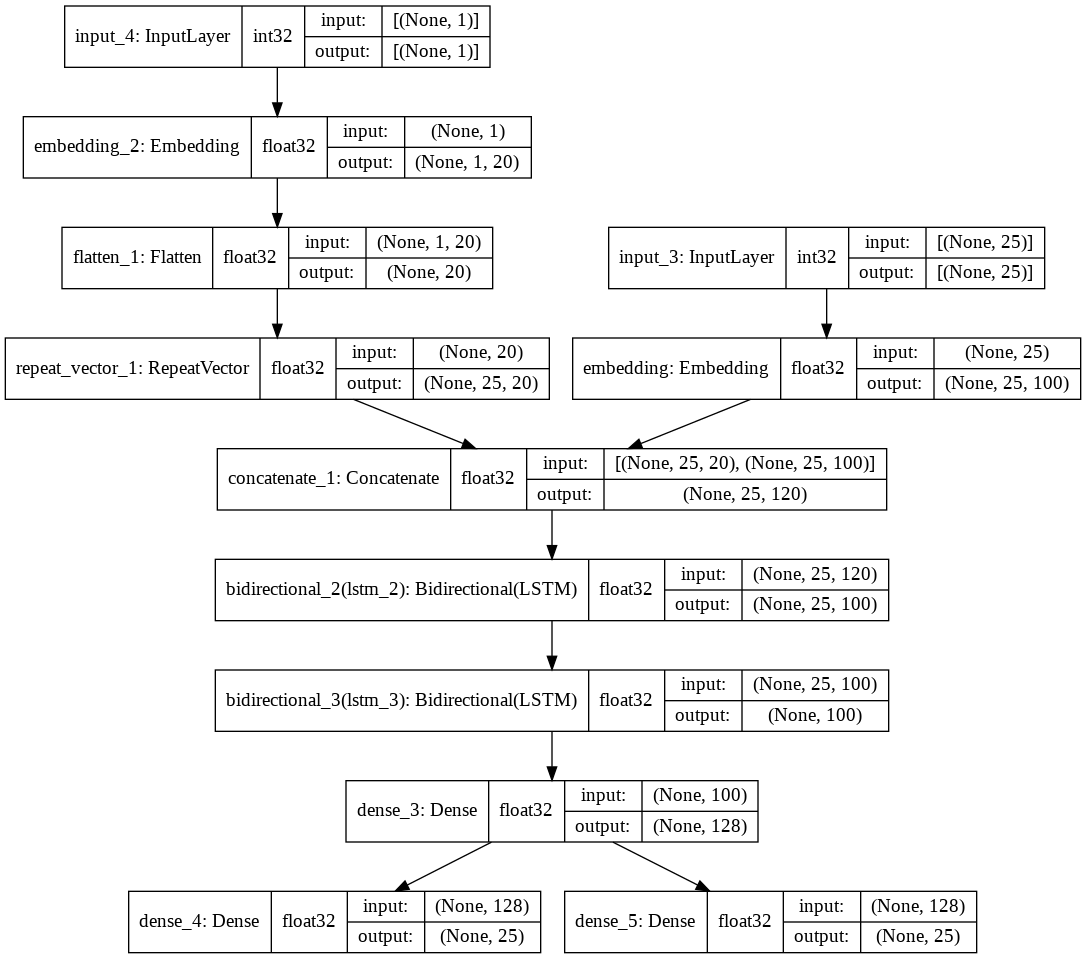

In [ ]:
tensorflow.keras.utils.plot_model(model, "rnn_model_sentiment.png",show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96,
    layer_range=None)

#Pedicción

In [ ]:
predi_,predf_ = model.predict([x_test,labels_test])

#Decodificación

In [ ]:
inicio,fin = [],[]
for i in range(predi_.shape[0]):
  k = np.argmax(predf_[i])
  j = np.argmax(predi_[i])
  inicio.append(j)
  fin.append(k) 


In [ ]:
def dec(x):
  l = []
  for i in x:
    vec = np.zeros(29)
    ind = np.append(vec[:i],1)
    pad = np.zeros(29-i)
    r = np.concatenate((ind,pad),axis=0)
    l.append(r.astype('float32'))
  return np.array(l)

In [ ]:
pred_ini = dec(inicio)
pred_fin = dec(fin)

In [ ]:
pred_ini[76 ],pred_ini[76 ]
inic1 = np.where(pred_ini[76 ]==1)[0][0]
finc1 = np.where(pred_fin[76 ]==1)[0][0]
print(finc1,inic1,fin[76 ],inicio[76 ])
print(pred_fin[76 ],pred_ini[76 ])

9 7 9 7
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [ ]:
y_test_f[0].shape[0]

25

Validación Negativos

In [ ]:
  for c in range(pred_ini.shape[0]):
    inic = np.where(pred_ini[c]==1)[0][0]
    finc = np.where(pred_fin[c]==1)[0][0]
    #a = np.ones(fin-inic)
    if (finc - inic) < 0:
      print(c,(finc-inic))

477 -1
761 -1
3249 -1
3864 -1


#Pading

In [ ]:
def fill(x,y):
  l = []
  for c in range(x.shape[0]):
    inic = np.where(x[c]==1)[0][0]
    fin = np.where(y[c]==1)[0][0]
    if inic > fin:
      inic = 0
    uno = np.append(np.zeros(29)[:inic],1)
    dos = np.concatenate((uno,np.ones((fin-inic))))
    r = np.concatenate((dos,(np.zeros(29-dos.shape[0]))))
    #res = np.concatenate((uno,tres),axis=0)
    #r = np.concatenate((res,tres),axis=0)
    l.append(r)
  return np.array(l)

In [ ]:
y_test = fill(y_test_i,y_test_f)

In [ ]:
y_pred = fill(pred_ini,pred_fin)

In [ ]:
y_pred

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [ ]:
type(y_pred[9])

numpy.ndarray

#Métricas construídas

In [ ]:
print('recall:{}'.format(recall_m(y_test,y_pred)))
print('precision:{}'.format(precision_m(y_test,y_pred)))
print('F1:{}'.format(f1_m(y_test,y_pred)))

recall:0.8296871457672313
precision:0.6452593996533466
F1:0.7259427739166857


In [ ]:
a

'hola mi nombre es Gufy y soy el mejor perro del mundo'

#Accuracy

In [ ]:
p = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    if y_test[n][l] == y_pred[n][l]:
      p = p + 1
print(p / (y_test.shape[0]*y_test.shape[1]),p)

0.9075356790309358 108485


#Precision

In [ ]:
fp = 0
tp = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    #if y_test[n][l] == 1:
      #tp = tp + 1
    if y_test[n][l] == y_pred[n][l] and y_pred[n][l] == 1:
      tp = tp + 1
    if y_test[n][l] != y_pred[n][l] and y_pred[n][l] == 1:
      fp = fp + 1 


print(tp/(tp+fp))

0.6452593996561907


#Recall

In [ ]:
fn = 0
tp = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    if y_test[n][l] == y_pred[n][l] and y_pred[n][l] == 1:
      tp = tp + 1
    if y_test[n][l] != y_pred[n][l] and y_pred[n][l] == 0:
      fn = fn + 1 


print(tp/(tp+fn))

0.8296871457719338


#Removiendo padding

In [ ]:
def withoutpadding(x,y):
  f = []
  for k,i in enumerate(x):
    a = i[:y[k]]
    f.append(a)
  return np.array(f)

In [ ]:
y_test_t = withoutpadding(y_test,long_test)
y_pred_p = withoutpadding(y_pred,long_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


Métricas

#Presicion sin padding

In [ ]:
fp = 0
tp = 0
for n in range(y_test_t.shape[0]):
  for l in range(y_test_t[n].shape[0]):
    #if y_test[n][l] == 1:
      #tp = tp + 1
    if y_test_t[n][l] == y_pred_p[n][l] and y_pred_p[n][l] == 1:
      tp = tp + 1
    if y_test_t[n][l] != y_pred_p[n][l] and y_pred_p[n][l] == 1:
      fp = fp + 1 


print(tp/(tp+fp))

0.6572917602659718


#Precisión con Padding

In [ ]:
fp = 0
tp = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    #if y_test[n][l] == 1:
      #tp = tp + 1
    if y_test[n][l] == y_pred[n][l] and y_pred[n][l] == 1:
      tp = tp + 1
    if y_test[n][l] != y_pred[n][l] and y_pred[n][l] == 1:
      fp = fp + 1 


print(tp/(tp+fp))

0.6452593996561907


#Accuracy sin padding

In [ ]:
p = 0
count = 0
for n in range(y_test_t.shape[0]):
  for l in range(y_test_t[n].shape[0]):
    count = count + 1
    if y_test_t[n][l] == y_pred_p[n][l]:
      p = p + 1
print(p / count)

0.6557414325158356


#Recall sin padding

In [ ]:
fn = 0
tp = 0
for n in range(y_test_t.shape[0]):
  for l in range(y_test_t[n].shape[0]):
    if y_test_t[n][l] == y_pred_p[n][l] and y_pred_p[n][l] == 1:
      tp = tp + 1
    if y_test_t[n][l] != y_pred_p[n][l] and y_pred_p[n][l] == 0:
      fn = fn + 1 


print(tp/(tp+fn))

0.83125


#Jaccard

In [ ]:
text_true = list(ts_test)

In [ ]:
text_true

Función dec jaccard

In [ ]:
def decjac(a,b):
  op=[]
  for i,j in enumerate(a):
    if j == 1:
      op.append(b.split()[i])
  return " ".join(op)

In [ ]:
j_test=[]
for ki in range(len(text_true)):
  j_test.append(decjac(y_test_t[ki],text_true[ki]))

In [ ]:
j_pred=[]
for kp in range(len(text_true)):
  j_pred.append(decjac(y_pred_p[kp],text_true[kp]))

In [ ]:
j_pred


In [ ]:
def jaccard(str1, str2):
    if len(str1) == 0 and len(str2) == 0:
      return 0.0
    else:
      a = set(str1.lower().split()) 
      b = set(str2.lower().split())
      c = a.intersection(b)
      return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
rest2 = [jaccard(j_test[i],j_pred[i]) for i in range(len(j_test))]

In [ ]:
print("el promedio de jaccard es: {}".format(round((sum(rest2)/len(rest2)),3)))

el promedio de jaccard es: 0.586
